In [37]:
# coding: utf-8
"""
AutoEncoderのサンプルコード
"""
import os

import chainer
from chainer.dataset import convert
from sklearn.datasets import load_digits, fetch_mldata
from sklearn.cross_validation import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sampleAE import AE
from sampleVAE import VAE
from sampleCVAE import CVAE

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
def train_model():

    if MODEL_NM == 'AE':
        model = AE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE)
    elif MODEL_NM == 'VAE':
        model = VAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE)
    elif MODEL_NM == 'CVAE':
        model = CVAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE, LABEL_SIZE)
    else:
        print('incorrect MODEL_NM')
        return

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    train_iter = chainer.iterators.SerialIterator(X_train, MINIBATCH_SIZE)

    for epoch in range(0, EPOCH_NUM):
        sum_loss = 0
        sum_rec_loss = 0

        batch = train_iter.next()
        x_array = convert.concat_examples(batch)
        x = chainer.Variable(x_array)
        # Update model based on the loss function
        # defined by model.get_loss_func()
        if MODEL_NM == 'AE':
            optimizer.update(model.get_loss_func(), x)
        elif MODEL_NM == 'VAE':
            optimizer.update(model.get_loss_func(C=0.1, k=10), x)
        elif MODEL_NM == 'CVAE':
            pass

        sum_loss += float(model.loss.data) * len(x.data)
        sum_rec_loss += float(model.rec_loss.data) * len(x.data)
        if epoch % 100 == 0:
            chainer.serializers.save_npz(
                os.path.join(OUTPUT_DIR, '{0}_{1}.model'.format(MODEL_NM, epoch)), model)
            # print('train mean loss={}, mean reconstruction loss={}'.format(sum_loss / train_count, sum_rec_loss / train_count))

    # Save the model and the optimizer
    # print('save the model')
    chainer.serializers.save_npz(
        os.path.join(OUTPUT_DIR, '{0}_{1}.model'.format(MODEL_NM, EPOCH_NUM)), model)
    
def train_for_cvae():

    model = CVAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE, LABEL_SIZE)

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    train_iter = chainer.iterators.SerialIterator(Xy_train, MINIBATCH_SIZE)

    for epoch in range(0, EPOCH_NUM):
        sum_loss = 0
        sum_rec_loss = 0

        batch = train_iter.next()
        x_array, t_array = convert.concat_examples(batch)
        x = chainer.Variable(x_array)
        t = chainer.Variable(t_array)
        # Update model based on the loss function
        # defined by model.get_loss_func()
        optimizer.update(model.get_loss_func(C=0.1, k=10), x, t)

        sum_loss += float(model.loss.data) * len(x.data)
        sum_rec_loss += float(model.rec_loss.data) * len(x.data)
        if epoch % 100 == 0:
            chainer.serializers.save_npz(
                os.path.join(OUTPUT_DIR, '{0}_{1}.model'.format(MODEL_NM, epoch)), model)
            # print('train mean loss={}, mean reconstruction loss={}'.format(sum_loss / train_count, sum_rec_loss / train_count))

    # Save the model and the optimizer
    # print('save the model')
    chainer.serializers.save_npz(
        os.path.join(OUTPUT_DIR, '{0}_{1}.model'.format(MODEL_NM, EPOCH_NUM)), model)
    
def test_plot():
    colors_dict = {
        0: '#ff2800',
        1: '#faf500',
        2: '#35a16b',
        3: '#0041ff',
        4: '#66ccff',
        5: '#ff99a0',
        6: '#ff9900',
        7: '#9a0079',
        8: '#663300',
        9: '#000000'
    }
    
    if MODEL_NM == 'AE':
        model = AE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE)
    elif MODEL_NM == 'VAE':
        model = VAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE)
    elif MODEL_NM == 'CVAE':
        model = CVAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE, LABEL_SIZE)
    else:
        print('incorrect MODEL_NM')
        return

    chainer.serializers.load_npz(MODEL_PATH, model)
    
    train_iter = chainer.iterators.SerialIterator(X_train, train_count, repeat=False, shuffle=False)

    with chainer.using_config('train', False), chainer.no_backprop_mode():
        batch = train_iter.next()
        x_array = convert.concat_examples(batch)
        x = chainer.Variable(x_array)
        x_mu, _ = model.encode(x)
    data_dict = {}
    for x, y in zip(x_mu.data, y_train):
        if y in data_dict:
            data_dict[y].append(x)
        else:
            data_dict[y] = [x]
    for y in range(0, 10):
        data = data_dict[y]
        xs = [row[0] for row in data]
        ys = [row[1] for row in data]
        plt.scatter(xs, ys, c=colors_dict[y], label=y, alpha=0.6)
    plt.title(MODEL_NM)
    plt.legend()
    plt.show()
    
def test_plot_for_cvae():
    colors_dict = {
        0: '#ff2800',
        1: '#faf500',
        2: '#35a16b',
        3: '#0041ff',
        4: '#66ccff',
        5: '#ff99a0',
        6: '#ff9900',
        7: '#9a0079',
        8: '#663300',
        9: '#000000'
    }
    
    model = CVAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE, LABEL_SIZE)

    chainer.serializers.load_npz(MODEL_PATH, model)
    
    train_iter = chainer.iterators.SerialIterator(Xy_test, train_count, repeat=False, shuffle=False)

    with chainer.using_config('train', False), chainer.no_backprop_mode():
        batch = train_iter.next()
        x_array, t_array = convert.concat_examples(batch)
        x = chainer.Variable(x_array)
        t = chainer.Variable(t_array)
        x_mu, _ = model.encode(x, t)
    data_dict = {}
    for x, y in zip(x_mu.data, y_train):
        if y in data_dict:
            data_dict[y].append(x)
        else:
            data_dict[y] = [x]
    for y in range(0, 10):
        data = data_dict[y]
        xs = [row[0] for row in data]
        ys = [row[1] for row in data]
        plt.scatter(xs, ys, c=colors_dict[y], label=y, alpha=0.6)
    plt.title(MODEL_NM)
    plt.legend()
    plt.show()
    
def test_kmeans():
    if MODEL_NM == 'AE':
        model = AE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE)
    elif MODEL_NM == 'VAE':
        model = VAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE)
    elif MODEL_NM == 'CVAE':
        model = CVAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE)
    else:
        print('incorrect MODEL_NM')
        return

    chainer.serializers.load_npz(MODEL_PATH, model)
    
    train_iter = chainer.iterators.SerialIterator(X_train, train_count, repeat=False, shuffle=False)

    with chainer.using_config('train', False), chainer.no_backprop_mode():
        batch = train_iter.next()
        x_array = convert.concat_examples(batch)
        x = chainer.Variable(x_array)
        x_mu, _ = model.encode(x)
    predicts = KMeans(n_clusters=10, random_state=0).fit_predict(x_mu.data)
    
    return v_measure_score(y_train, predicts)

def test_kmeans_for_cvae():
    model = CVAE(INPUT_SIZE, Z_SIZE, HIDDEN_SIZE, LABEL_SIZE)

    chainer.serializers.load_npz(MODEL_PATH, model)
    
    train_iter = chainer.iterators.SerialIterator(Xy_test, train_count, repeat=False, shuffle=False)

    with chainer.using_config('train', False), chainer.no_backprop_mode():
        batch = train_iter.next()
        x_array, t_array = convert.concat_examples(batch)
        x = chainer.Variable(x_array)
        t = chainer.Variable(t_array)
        x_mu, _ = model.encode(x, t)
    predicts = KMeans(n_clusters=10, random_state=0).fit_predict(x_mu.data)
    
    return v_measure_score(y_train, predicts)

# 学習データの作成

In [68]:
# Load the MNIST dataset
digits = load_digits()

X_train, y_train = digits.data, digits.target

X_train = X_train / 16.0

X_train = X_train.astype('float32')
y_train = y_train.astype('int32')
y_half_train = np.concatenate([y_train[0:200], -1*np.ones(train_count-200)]).astype('int32')

train_count = len(X_train)
Xy_train = [(x , y) for x, y in zip(X_train, y_half_train)]
Xy_test = [(x , -1) for x, y in zip(X_train, y_train)]

print('train_size: ', train_count)

train_size:  1797


# AEのテスト

## 学習

In [78]:
MODEL_NM = 'AE'
Z_SIZE = 2
EPOCH_NUM = 1000
INPUT_SIZE = 64
HIDDEN_SIZE = 64
MINIBATCH_SIZE = 10
TEST_FLAG = False
OUTPUT_DIR = './files/'

train_model()

## プロット

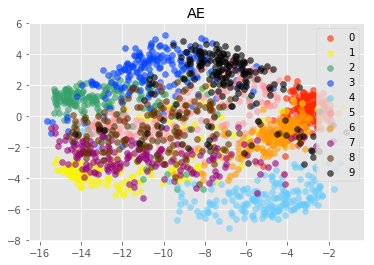

In [79]:
MODEL_PATH = './files/AE_1000.model'

test_model()

## クラスタリングでの評価

In [95]:
MODEL_NM = 'AE'
Z_SIZE = 16
EPOCH_NUM = 500
INPUT_SIZE = 64
HIDDEN_SIZE = 64
MINIBATCH_SIZE = 10
TEST_FLAG = False
OUTPUT_DIR = './files/'
MODEL_PATH = './files/AE_500.model'

score_ae = []

for _ in range(50):
    train_model()
    score_ae.append(test_kmeans())

# VAE

## 学習

In [99]:
MODEL_NM = 'VAE'
Z_SIZE = 2
EPOCH_NUM = 500
INPUT_SIZE = 64
HIDDEN_SIZE = 64
MINIBATCH_SIZE = 10
TEST_FLAG = False
OUTPUT_DIR = './files/'

train_model()

## プロット

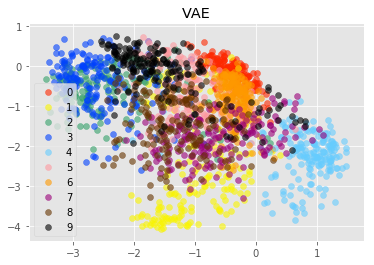

In [100]:
MODEL_PATH = './files/VAE_1000.model'

test_model()

## クラスタリングでの評価

In [96]:
MODEL_NM = 'VAE'
Z_SIZE = 16
EPOCH_NUM = 500
INPUT_SIZE = 64
HIDDEN_SIZE = 64
MINIBATCH_SIZE = 10
TEST_FLAG = False
OUTPUT_DIR = './files/'
MODEL_PATH = './files/VAE_500.model'

score_vae = []
for _ in range(50):
    train_model()
    score_vae.append(test_kmeans())

# CVAE

## 学習

In [101]:
MODEL_NM = 'CVAE'
LABEL_SIZE = 10
Z_SIZE = 2
EPOCH_NUM = 1000
INPUT_SIZE = 64
HIDDEN_SIZE = 64
MINIBATCH_SIZE = 10
TEST_FLAG = False
OUTPUT_DIR = './files/'

train_for_cvae()

## プロット

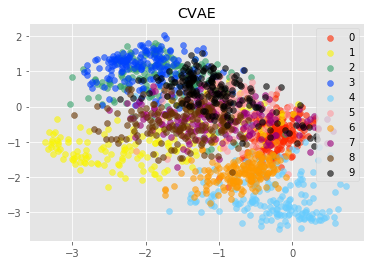

In [102]:
MODEL_PATH = './files/CVAE_1000.model'

test_plot_for_cvae()

## クラスタリングでの評価

In [97]:
MODEL_NM = 'CVAE'
Z_SIZE = 16
LABEL_SIZE = 10
EPOCH_NUM = 500
INPUT_SIZE = 64
HIDDEN_SIZE = 64
MINIBATCH_SIZE = 10
TEST_FLAG = False
OUTPUT_DIR = './files/'
MODEL_PATH = './files/CVAE_500.model'

score_cvae = []
for _ in range(50):
    train_for_cvae()
    score_cvae.append(test_kmeans_for_cvae())

# クラスタリングの結果を比較

No handles with labels found to put in legend.


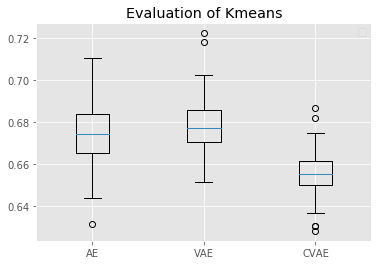

In [98]:
fig = plt.figure()
ax = fig.add_subplot(111)

bp = ax.boxplot((score_ae, score_vae, score_cvae))
ax.set_xticklabels(['AE', 'VAE', 'CVAE'])
plt.legend()
plt.title('Evaluation of Kmeans')
plt.show()